# Project 4

## ECE3311 "Principles of Communication Systems" (B-Term 2020)

## Python Scripts

In [1]:
# Remember to install GNU Radio on your workstation using "sudo apt install gnuradio"
from gnuradio import gr, digital, filter
from gnuradio import blocks
from gnuradio import channels
from gnuradio import eng_notation
from gnuradio.eng_arg import eng_float, intx
import sys
import numpy as np
import math
import matplotlib.pyplot as plt

# Section 4: Basic Experimentation

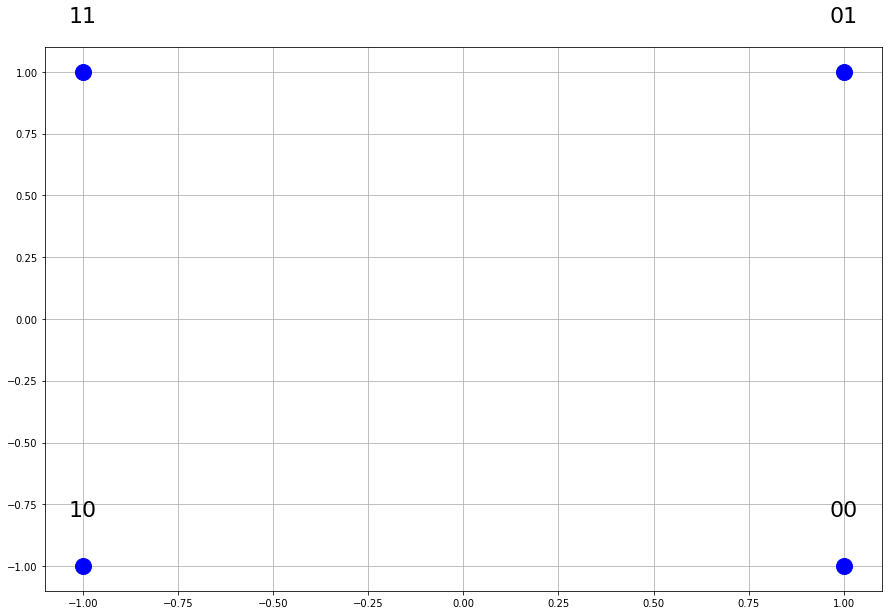

In [2]:
# Generate the mapping from binary to complex baseband representations for QPSK (also graph signal constellation diagram)

bps = 2 # bits per symbol 2 - QPSK, 4 - 16QAM, 6 - 64QAM
total_qpsk_symbols = 1000*bps
mapping_table = {
    (1,0) : -1-1j,
    (1,1) : -1+1j,
    (0,0) :  1-1j,
    (0,1) :  1+1j
}
plt.figure(figsize=(15,10))
for b1 in [0, 1]:
    for b0 in [0, 1]:
        B = (b1, b0)
        Q = mapping_table[B]
        plt.plot(Q.real, Q.imag, 'bo', markersize=16)
        plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center', fontsize=22)

plt.grid()
plt.show()

In [3]:
# Generate binary data stream and map it to QPSK symbols

bits = np.random.binomial(n=1, p=0.5, size=(total_qpsk_symbols, ))
def packing(bits):
    return bits.reshape((1000, bps))
bits_packed = packing(bits)
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_packed)

[-1.-1.j -1.+1.j -1.-1.j  1.-1.j -1.+1.j -1.+1.j  1.+1.j  1.-1.j  1.-1.j
  1.-1.j  1.+1.j -1.+1.j -1.-1.j -1.-1.j -1.-1.j -1.+1.j -1.-1.j  1.+1.j
  1.+1.j -1.+1.j  1.-1.j  1.+1.j -1.+1.j -1.+1.j -1.-1.j  1.+1.j  1.-1.j
 -1.-1.j  1.+1.j -1.-1.j -1.-1.j -1.+1.j -1.+1.j  1.+1.j  1.-1.j  1.-1.j
  1.-1.j  1.+1.j -1.-1.j -1.+1.j -1.+1.j -1.-1.j  1.-1.j -1.-1.j -1.-1.j
 -1.-1.j -1.-1.j -1.-1.j  1.-1.j  1.-1.j  1.-1.j  1.+1.j  1.-1.j -1.-1.j
  1.+1.j  1.-1.j  1.-1.j -1.+1.j -1.+1.j -1.+1.j  1.-1.j -1.-1.j -1.-1.j
 -1.+1.j -1.-1.j -1.-1.j -1.-1.j -1.+1.j -1.-1.j  1.-1.j  1.-1.j  1.+1.j
 -1.+1.j  1.+1.j -1.+1.j  1.+1.j  1.-1.j  1.-1.j -1.-1.j -1.-1.j  1.+1.j
  1.+1.j -1.-1.j -1.-1.j -1.+1.j -1.+1.j  1.+1.j  1.+1.j -1.-1.j -1.+1.j
  1.-1.j -1.-1.j  1.+1.j  1.-1.j -1.+1.j  1.-1.j -1.-1.j  1.-1.j -1.-1.j
  1.+1.j -1.-1.j -1.-1.j -1.+1.j  1.+1.j -1.+1.j  1.+1.j  1.-1.j  1.-1.j
  1.+1.j  1.-1.j -1.-1.j -1.+1.j  1.-1.j  1.+1.j  1.+1.j -1.+1.j -1.+1.j
 -1.-1.j -1.+1.j  1.+1.j  1.+1.j  1.-1.j  1.+1.j -1

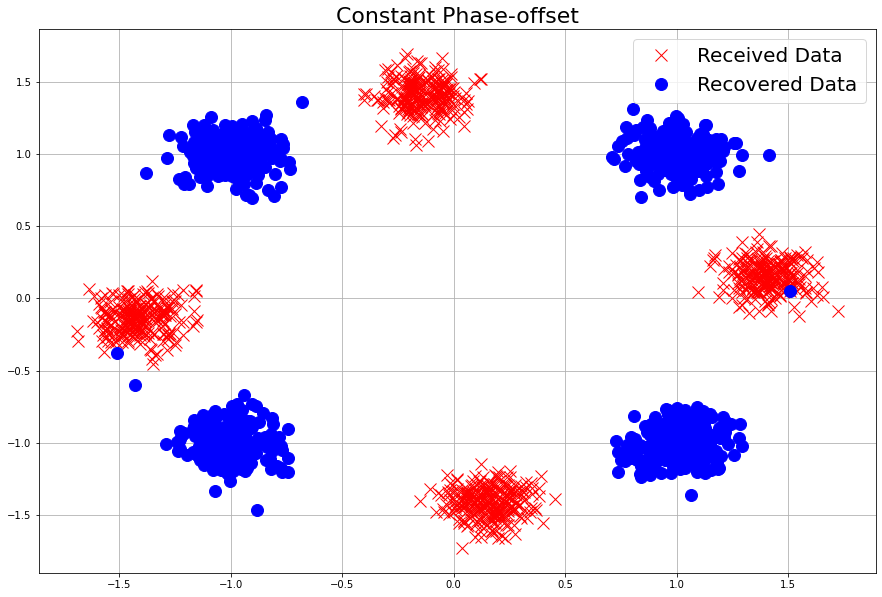

In [4]:
# Costas Loop implementation using GNU Radio code
# This code should be used as a template for the rest of this project

phaseoffset=0.89 # Defining constant phase offset for this section of the project
data = np.exp(1j*phaseoffset) * QAM

tb = gr.top_block() # Calling on GNU Radio top block model
src = blocks.vector_source_c(data.tolist(), False)
noise = 0.15
foffset = 0.0
toffset = 1.0
chn = channels.channel_model(noise, foffset, toffset)
chn1 = channels.channel_model(noise, foffset, toffset)

# Define Costas Loop parameters
bw = 2*np.pi/100  # Loop bandwidth W_L
M = 4 # Modulation order (in this case, it is QPSK)
df = 0.5 # Damping factor \zeta

# Calling GNU Radio block for Costas Loop
cst = digital.costas_loop_cc(bw, M)
cst.set_damping_factor(df)
sink = blocks.vector_sink_c()  # Output of Costas Loop (phase compensated)
sinkrx = blocks.vector_sink_c() # Input to Costas Loop (corrupted signal)
sinkfreq = blocks.vector_sink_f()
sinkphase = blocks.vector_sink_f()
sinkerror = blocks.vector_sink_f()
tb.connect(src,chn,cst, sink) # signal compensated by costas loop
tb.connect(src,chn1, sinkrx) # signal not compensated by costas loop
tb.connect((cst,1),sinkfreq) # Costas Loop frequency output
tb.connect((cst,2),sinkphase) # Costas Loop phase output
tb.connect((cst,3),sinkerror) # Costas Loop error output
tb.run()
tb.stop()
out = np.array(sink.data()) # after costas
rxsig = np.array(sinkrx.data()) # before costas
error = np.array(sinkerror.data()) # difference between the two

# Produce signal constellation diagram showing difference between 
# phase corrupted received data and compensated recovered data via Costas Loop
plt.figure(figsize=(15,10))
plt.plot(rxsig.real, rxsig.imag, 'rx', markersize=12, label='Received Data')
plt.plot(out.real, out.imag, 'bo', markersize=12, label='Recovered Data')
plt.legend(fontsize=20)
plt.title('Constant Phase-offset', fontsize=22)
plt.grid(True)

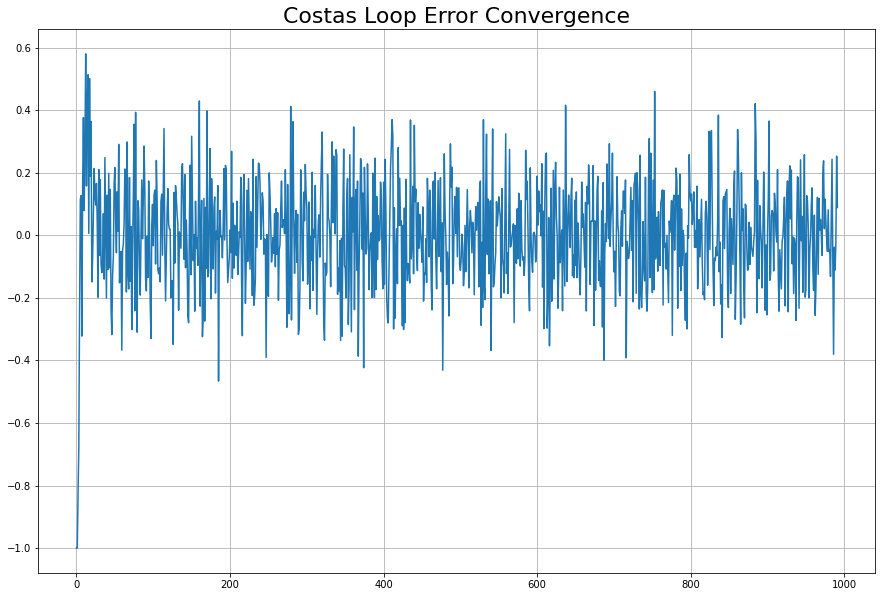

In [5]:
# Phase error convergence plot
plt.figure(figsize=(15,10))
plt.plot(error)
plt.title('Costas Loop Error Convergence', fontsize=22)
plt.grid(True)

# Section 5: Time-Varying Phase

In [6]:
# Time-varying phase scenario 1: linearly increasing phase
#
# Only the phase values as a function of time are provided
# Please use example code from Section 4 to implement Costas Loop

phaseoffset=np.linspace(0, 0.85,len(QAM))
data = np.exp(1j*phaseoffset) * QAM

In [7]:
# Time-varying phase scenario 2: unit step function phase change
#
# Only the phase values as a function of time are provided
# Please use example code from Section 4 to implement Costas Loop

phaseoffset0 = [-0.5]*500
phaseoffset1 =[0.5]*500
phaseoffset = np.append(phaseoffset0, phaseoffset1, axis=0)
data = np.exp(1j*phaseoffset) * QAM

In [8]:
# Time-varying phase scenario 3: sine function phase variation
#
# Only the phase values as a function of time are provided
# Please use example code from Section 4 to implement Costas Loop

phaseoffset = np.sin(np.linspace(-np.pi,np.pi,len(QAM)))
data = np.exp(1j*phaseoffset) * QAM

# Section 6: Mystery Signal Constellations

In [9]:
# Mystery signal 1
#
# There are 1000 symbols that either belong to BPSK, QPSK, or 8PSK
# Need to find appropriate loop filter bandwidth W_L and damping factor \zeta to obtain phase lock
# Use example code from Section 4

mysterysignal1=np.load('mysterysignal1.npy') # Load mystery signal 1 data from .npy file

In [10]:
# Mystery signal 2
#
# There are 1000 symbols that either belong to BPSK, QPSK, or 8PSK
# Need to find appropriate loop filter bandwidth W_L and damping factor \zeta to obtain phase lock
# Use example code from Section 4

mysterysignal2=np.load('mysterysignal2.npy') # Load mystery signal 2 data from .npy file

In [11]:
# Mystery signal 3
#
# There are 1000 symbols that either belong to BPSK, QPSK, or 8PSK
# Need to find appropriate loop filter bandwidth W_L and damping factor \zeta to obtain phase lock
# Use example code from Section 4

mysterysignal3=np.load('mysterysignal3.npy') # Load mystery signal 3 data from .npy file